In [1]:
import hashlib
import os
import pickle
from hwcomponents_cacti import SRAM as CactiSRAM
from hwcomponents_library import AladdinAdder, AladdinMultiplier

from fastfusion.frontend.arch import Memory
from fastfusion.frontend.specification import Specification
from fastfusion.mapper.FFM._make_pmappings.mapper_multi_einsum import get_sims
from fastfusion.mapper.simanneal.wrappers import join_sims

import copy
import time
from fastfusion import Specification
from fastfusion.mapper.metrics import Metrics
from fastfusion.mapper.FFM._make_pmappings.mapper_multi_einsum import get_sims
from fastfusion.mapper.FFM._join_pmappings.sim import SIM
from fastfusion.mapper.FFM._join_pmappings.simexplore import join_sims
import fastfusion.mapper.FFM._make_pmappings.mapper_one_einsum as mapper_one_einsum

from fastfusion.mapper.FFM._make_pmappings.mapping_filter_tags.ffmt import get_ffmt_tag
from fastfusion.mapper.FFM._make_pmappings.mapping_filter_tags.onesplit import get_one_split_tag
from fastfusion.mapper.FFM._pmapping_group import PmappingGroup
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

# TODO: Make a setting for the below two in the spec
# TODO: Generate pmappings one Einsum at a time. Once we've made compatibility, check it
# against the previously-generated compatibilities and stop if there's no match.
# TODO: Once the previous is done, also add a forward check. Once the compatibilities of
# a particular Einsum are generated, we can immediately check the previous Einsums.

objective = lambda df: df['Total\0latency']# * df['Total_Energy']
LOAD_FROM_CACHE = True

def get_fused_mappings(
        spec: Specification, 
        cache_key=None,
        parameterization="",
    ) -> PmappingGroup:
    os.makedirs("cache", exist_ok=True)
    if cache_key is not None:
        fname = parameterization + "-".join(str(x) for x in cache_key)
        if LOAD_FROM_CACHE and os.path.exists(f"cache/{fname}.pkl"):
            print(f"Loading from cache: {fname}")
            mappings = pickle.load(open(f"cache/{fname}.pkl", "rb"))
            return objective(mappings.data).min() if mappings is not None else None, mappings
    spec = copy.deepcopy(spec)
    
    main_memory: Memory = spec.arch.nodes["MainMemory"]
    if parameterization == "Unfused":
        main_memory.constraints.tensors.keep = "All()"
    elif parameterization == "FlashAttention B":
        main_memory.constraints.tensors.keep = "~bypass"
        main_memory.constraints.tensors.bypass = "I | Q | K | V | QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FlashAttention A":
        main_memory.constraints.tensors.keep = "~bypass"
        main_memory.constraints.tensors.bypass = "QK | QK_softmax"#Q | K | V | I"# | QK | FFA"
    elif parameterization == "FFM":
        main_memory.constraints.tensors.keep = "~Intermediates()" #"# | AV | Z "
        pass
    elif parameterization == "Fixed-Dataflow":
        main_memory.constraints.tensors.keep = "~Intermediates() | weight"
        spec.arch.nodes["GlobalBuffer"].constraints.dataflow.tensor_order_options = [
            ["MainMemory.tensors() & weight", "MainMemory.tensors() & input", "MainMemory.tensors() & output", "weight - MainMemory.tensors()", "input - MainMemory.tensors()", "output - MainMemory.tensors()"],
        ]
    else:
        assert False, f"Parameterization {parameterization} not supported"
    
    spec.calculate_component_energy_area()
    if LOAD_FROM_CACHE and cache_key is not None and os.path.exists(f"pmappings_cache/{fname}.pkl"):
        print(f"Loading from cache: {fname}")
        pmappings = pickle.load(open(f"cache/pmappings_{fname}.pkl", "rb"))
    else:
        pmappings = make_pmappings(spec)
        pickle.dump(pmappings, open(f"cache/pmappings_{fname}.pkl", "wb"))
    try:
        mappings = join_pmappings(spec, pmappings)
    except:
        mappings = None

    # TODO: the final joined pmappings have lambdas somewhere, which can't be pickled.
    if cache_key is not None:
        pickle.dump(mappings, open(f"cache/{fname}.pkl", "wb"))
        
    return objective(mappings.data).min() if mappings is not None else None, mappings

parameterization2edp = {}
parameterization2mappings = {}

parameterizations = ["Unfused", "FlashAttention A", "FlashAttention B", "Fixed-Dataflow", "FFM"]
# for batch_size, n_tokens in [(64, 512), (1, 8192), (1, 16384), (1, 32768), (64, 8192), (64, 16384), (64, 32768)]:
for batch_size, n_tokens in [(64, 512), (1, 8192), (1, 32768)]:
        for n_pes in [256]:# [64, 256]:
            spec = Specification.from_yaml(
                f"architecture/tpu_like_asplos.arch.yaml",
                "workloads/mha_full.workload.yaml",
                "workloads/mha_full.renames.yaml",
                jinja_parse_data={
                    "BATCH_SIZE": batch_size,
                    "N_TOKENS": n_tokens,
                    "N_PES": n_pes,
                }
            )
            spec.mapper.ffm.metrics = Metrics.LATENCY
            cache_key = (batch_size, n_tokens, n_pes)
            spec.arch.nodes["LocalBuffer"].spatial["Z"].fanout = n_pes
            for parameterization in parameterizations:
                x, mappings = get_fused_mappings(
                    spec,
                    cache_key=cache_key,
                    parameterization=parameterization,
                )
                parameterization2edp.setdefault((batch_size, n_tokens, n_pes), {})[parameterization] = x
                parameterization2mappings.setdefault((batch_size, n_tokens, n_pes), {})[parameterization] = mappings

WARNING Loading configuration file from /root/.config/fastfusion/config.yaml


Generating pmappings for compute node scalar_unit


Generating tensor order and loop choices for Einsum I: 1it [00:00, 13.98it/s]
Generating tensor order and loop choices for Einsum V: 0it [00:00, ?it/s]s]
Generating tensor order and loop choices for Einsum Z: 0it [00:00, ?it/s]]
Generating tensor order and loop choices for Einsum FFB: 0it [00:00, ?it/s] ?it/s]
Generating tensor order and loop choices for Einsum FFA: 0it [00:00, ?it/s]
Generating tensor order and loop choices for Einsum AV: 0it [00:00, ?it/s]
Generating tensor order and loop choices for Einsum QK: 0it [00:00, ?it/s]
Generating tensor order and loop choices for Einsum Q: 0it [00:00, ?it/s]
Generating tensor order and loop choices for Einsum K: 0it [00:00, ?it/s]
Generating tensor order and loop choices for Einsum QK_softmax: 2it [00:00, 23.12it/s]
Generating jobs: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
WARNING Einsum I has 1 bypass choices:
WARNING 	[I_in,I in MainMemory] S-Z-b,d,m T-b,d,m scalar_unit computes I
WARNING Einsum V has 0 bypass choices:
WARNING Ein

Generated 1 job for I
Generated 0 jobs for V
Generated 0 jobs for K
Generated 0 jobs for Q
Generated 0 jobs for QK
Generated 2 jobs for QK_softmax
Generated 0 jobs for AV
Generated 0 jobs for Z
Generated 0 jobs for FFA
Generated 0 jobs for FFB
V
Q
WFFA
QK
WFFB
FFA
WK
I
I_in
WQ
QK_softmax
AV
FFB
Z
WV
WZ
K


Generating pmappings:   0%|          | 0/3 [00:00<?, ?it/s]

Reduced from 63 to 63
Reduced from 63 to 63
Reduced from 81 to 81
Nominal n mappings: 910
Actual n mappings: 161
Ratio: 0.17692307692307693
Product of ratios: 0.17976377667848764
Product of ratios: 0.03180436048927089
Reduced from 42 to 42
Reduced from 63 to 63
Reduced from 63 to 63
Reduced from 54 to 54
Reduced from 54 to 54
Reduced from 81 to 81
Reduced from 42 to 42
Reduced from 63 to 63
Reduced from 63 to 63
Reduced from 54 to 54
Reduced from 54 to 54
Reduced from 81 to 81
Nominal n mappings: 4200
Actual n mappings: 475
Ratio: 0.1130952380952381
Product of ratios: 0.014884381636519759
Product of ratios: 0.001683352685082592
Nominal n mappings: 4200
Actual n mappings: 475
Ratio: 0.1130952380952381
Product of ratios: 0.014884381636519759
Product of ratios: 0.001683352685082592


Generating pmappings: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Generating pmappings for compute node MAC


Generating tensor order and loop choices for Einsum I: 0it [00:00, ?it/s]s] ?it/s]
Generating tensor order and loop choices for Einsum QK_softmax: 0it [00:00, ?it/s]
Generating tensor order and loop choices for Einsum QK: 8it [00:00, 50.31it/s]
Generating tensor order and loop choices for Einsum K: 8it [00:00, 48.89it/s]s]
Generating tensor order and loop choices for Einsum Q: 8it [00:00, 45.06it/s]
Generating tensor order and loop choices for Einsum FFB: 8it [00:00, 45.44it/s]
Generating tensor order and loop choices for Einsum AV: 8it [00:00, 43.01it/s]




































































































Generated 0 jobs for I
































































































































































































































































































































































































































































































































































Generating tensor order and loop choices for Einsum FFA: 8it [00:00, 51.88it/s]
Generating tensor order and loop choices for Einsum Z: 8it [00:00, 49.74it/s]
Generating tensor order and loop choices for Einsum V: 8it [00:00, 52.60it/s]
Generating jobs: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]
WARNING Einsum I has 0 bypass choices:
WARNING Einsum V has 8 bypass choices:
WARNING 	[WV,V,I in MainMemory] T-b,d,m [I in GlobalBuffer] T-e,h [V in GlobalBuffer] S-Y-d S-X-e,h S-Z-b,m T-d [WV in Register] T-b,m MAC computes V
WARNING 	[WV,V,I in MainMemory] T-b,e,h,m [V in GlobalBuffer] T-d [I in GlobalBuffer] S-Y-d S-X-e,h S-Z-b,m T-e,h [WV in Register] T-b,m MAC computes V
WARNING 	[WV,V,I in MainMemory] T-b,d,m [I in GlobalBuffer] T-e,h [V in GlobalBuffer] T-d [WV in GlobalBuffer] S-Y-d S-X-e,h S-Z-b,m T-b,m MAC computes V
WARNING 	[WV,V,I in MainMemory] T-b,d,m [I in GlobalBuffer] T-e,h [WV in GlobalBuffer] T-b,m [V in GlobalBuffer] S-Y-d S-X-e,h S-Z-b,m T-d MAC computes V
WARNING 	[W

Generated 8 jobs for V
Generated 8 jobs for K
Generated 8 jobs for Q
Generated 8 jobs for QK
Generated 0 jobs for QK_softmax
Generated 8 jobs for AV
Generated 8 jobs for Z
Generated 8 jobs for FFA
Generated 8 jobs for FFB
V
Q
WFFA
QK
WFFB
FFA
WK
I
I_in
WQ
QK_softmax
AV
FFB
Z
WV
WZ
K


Generating pmappings:   0%|          | 0/64 [00:00<?, ?it/s]

Reduced from 1008 to 1008
Reduced from 588 to 588
Reduced from 2128 to 2128Reduced from 1512 to 1512

Reduced from 2128 to 2128
Reduced from 224 to 224
Reduced from 1512 to 1512Reduced from 1512 to 1512

Reduced from 756 to 756
Reduced from 224 to 224
Reduced from 224 to 224
Reduced from 168 to 168Reduced from 168 to 168

Reduced from 1944 to 1944
Reduced from 288 to 288
Reduced from 1134 to 1134
Reduced from 168 to 168
Reduced from 4104 to 4104
Reduced from 4104 to 4104
Reduced from 432 to 432
Reduced from 608 to 608
Reduced from 608 to 608
Reduced from 456 to 456Reduced from 456 to 456

Reduced from 432 to 432Reduced from 432 to 432

Reduced from 324 to 324
Reduced from 324 to 324
Reduced from 48 to 48
Reduced from 48 to 48
Reduced from 2128 to 2128
Reduced from 1512 to 1512
Reduced from 224 to 224
Reduced from 168 to 168
Reduced from 2736 to 2736
Reduced from 1008 to 1008
Reduced from 1596 to 1596
Reduced from 4104 to 4104
Reduced from 1008 to 1008
Reduced from 588 to 588
Reduced fr

Generating pmappings:   5%|▍         | 3/64 [00:08<02:10,  2.14s/it]

Reduced from 1 to 1
Reduced from 54 to 54
Reduced from 52 to 52
Reduced from 8 to 8
Reduced from 54 to 54
Reduced from 52 to 52
Reduced from 8 to 8
Reduced from 2808 to 2808
Reduced from 432 to 432
Reduced from 416 to 416
Nominal n mappings: 24200
Actual n mappings: 22464
Ratio: 0.9282644628099174
Product of ratios: 0.9282644628099174
Product of ratios: 0.8616749129157845


Generating pmappings:   6%|▋         | 4/64 [00:08<01:38,  1.64s/it]

Reduced from 36 to 36
Reduced from 1 to 1
Reduced from 54 to 54
Reduced from 8 to 8
Reduced from 36 to 36
Reduced from 1944 to 1944
Reduced from 288 to 288
Reduced from 54 to 54
Reduced from 8 to 8
Reduced from 432 to 432
Nominal n mappings: 19800
Actual n mappings: 15552
Ratio: 0.7854545454545454
Product of ratios: 0.7854545454545455
Product of ratios: 0.6169388429752066


Generating pmappings:   8%|▊         | 5/64 [00:09<01:14,  1.27s/it]

Reduced from 36 to 36
Reduced from 1 to 1
Reduced from 54 to 54
Reduced from 8 to 8
Reduced from 36 to 36
Reduced from 1944 to 1944
Reduced from 288 to 288
Reduced from 54 to 54
Reduced from 8 to 8
Reduced from 432 to 432
Nominal n mappings: 19800
Actual n mappings: 15552
Ratio: 0.7854545454545454

Generating pmappings:   9%|▉         | 6/64 [00:09<00:55,  1.05it/s]


Product of ratios: 0.7854545454545455
Product of ratios: 0.6169388429752066


Generating pmappings:  16%|█▌        | 10/64 [00:10<00:22,  2.43it/s]

Reduced from 1 to 1
Reduced from 54 to 54
Reduced from 52 to 52
Reduced from 8 to 8
Reduced from 54 to 54
Reduced from 52 to 52
Reduced from 8 to 8
Reduced from 2808 to 2808
Reduced from 432 to 432
Reduced from 416 to 416
Reduced from 36 to 36
Reduced from 1 to 1
Reduced from 54 to 54
Reduced from 8 to 8
Reduced from 36 to 36
Reduced from 1944 to 1944
Reduced from 288 to 288
Reduced from 54 to 54
Reduced from 8 to 8
Reduced from 432 to 432
Reduced from 36 to 36
Reduced from 1 to 1
Reduced from 52 to 52
Reduced from 9 to 9
Reduced from 36 to 36
Reduced from 1872 to 1872
Reduced from 324 to 324
Reduced from 52 to 52
Reduced from 9 to 9
Reduced from 468 to 468
Reduced from 36 to 36
Reduced from 1 to 1
Reduced from 52 to 52
Reduced from 9 to 9
Reduced from 36 to 36
Reduced from 1872 to 1872
Reduced from 324 to 324
Reduced from 52 to 52
Reduced from 9 to 9
Reduced from 468 to 468
Nominal n mappings: 24200
Actual n mappings: 22464
Ratio: 0.9282644628099174
Product of ratios: 0.92826446280991

Generating pmappings:  17%|█▋        | 11/64 [00:10<00:19,  2.76it/s]

Product of ratios: 0.8616749129157845
Nominal n mappings: 19800
Actual n mappings: 15552
Ratio: 0.7854545454545454
Product of ratios: 0.7854545454545455
Product of ratios: 0.6169388429752066
Nominal n mappings: 19800
Actual n mappings: 16848
Ratio: 0.850909090909091
Product of ratios: 0.850909090909091
Product of ratios: 0.7240462809917355
Nominal n mappings: 19800
Actual n mappings: 16848
Ratio: 0.850909090909091
Product of ratios: 0.850909090909091
Product of ratios: 0.7240462809917355


Generating pmappings:  19%|█▉        | 12/64 [00:10<00:16,  3.15it/s]

Reduced from 1 to 1
Reduced from 54 to 54
Reduced from 52 to 52
Reduced from 8 to 8
Reduced from 54 to 54
Reduced from 52 to 52
Reduced from 8 to 8
Reduced from 2808 to 2808
Reduced from 432 to 432
Reduced from 416 to 416
Reduced from 2128 to 2128
Reduced from 1512 to 1512
Reduced from 224 to 224
Reduced from 168 to 168
Reduced from 4104 to 4104
Reduced from 608 to 608
Reduced from 456 to 456
Reduced from 432 to 432
Nominal n mappings: 24200Reduced from 324 to 324

Actual n mappings: 22464
Ratio: 0.9282644628099174
Product of ratios: 0.9282644628099174
Product of ratios: 0.8616749129157845
Reduced from 48 to 48
Reduced from 1008 to 1008
Reduced from 588 to 588
Reduced from 1512 to 1512
Reduced from 224 to 224
Reduced from 756 to 756
Reduced from 1944 to 1944
Reduced from 288 to 288
Reduced from 1134 to 1134
Reduced from 168 to 168
Reduced from 432 to 432
Reduced from 1008 to 1008
Reduced from 588 to 588
Reduced from 1512 to 1512
Reduced from 224 to 224
Reduced from 756 to 756
Reduced f

Generating pmappings:  25%|██▌       | 16/64 [00:11<00:10,  4.68it/s]

Reduced from 2128 to 2128
Reduced from 1512 to 1512
Reduced from 224 to 224
Reduced from 168 to 168
Reduced from 2736 to 2736
Reduced from 756 to 756
Reduced from 252 to 252
Reduced from 324 to 324
Reduced from 1596 to 1596
Reduced from 532 to 532
Reduced from 684 to 684
Reduced from 147 to 147
Reduced from 189 to 189
Reduced from 63 to 63
Reduced from 4104 to 4104
Reduced from 608 to 608
Reduced from 456 to 456
Reduced from 432 to 432
Reduced from 324 to 324
Reduced from 48 to 48
Reduced from 1008 to 1008
Reduced from 588 to 588
Reduced from 2736 to 2736
Reduced from 1512 to 1512
Reduced from 224 to 224
Reduced from 756 to 756
Reduced from 756 to 756
Reduced from 252 to 252
Reduced from 324 to 324
Reduced from 1944 to 1944
Reduced from 288 to 288
Reduced from 1134 to 1134
Reduced from 1596 to 1596
Reduced from 168 to 168Reduced from 532 to 532

Reduced from 432 to 432
Reduced from 684 to 684
Reduced from 147 to 147
Reduced from 189 to 189
Reduced from 63 to 63
Reduced from 2128 to 212

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

Elementwise-Only: {'Batch=64\nTokens=512': np.float64(0.3415307750205844), 'Batch=1\nTokens=8k': np.float64(0.04927433922747447), 'Batch=1\nTokens=32k': np.float64(0.02675507038893531)}
FlashAttention A: {'Batch=64\nTokens=512': np.float64(0.45744447885984596), 'Batch=1\nTokens=8k': np.float64(0.47993180829615223), 'Batch=1\nTokens=32k': np.float64(0.6504716129657209)}
FlashAttention B: {'Batch=64\nTokens=512': np.float64(0.6349826650381478), 'Batch=1\nTokens=8k': np.float64(0.6181579163585571), 'Batch=1\nTokens=32k': np.float64(0.0)}
Fixed-Dataflow: {'Batch=64\nTokens=512': np.float64(0.6770154779597468), 'Batch=1\nTokens=8k': np.float64(0.7933776231150481), 'Batch=1\nTokens=32k': np.float64(0.7128056165316785)}
Fast & Fusiest: {'Batch=64\nTokens=512': np.float64(1.0), 'Batch=1\nTokens=8k': np.float64(1.0), 'Batch=1\nTokens=32k': np.float64(1.0)}


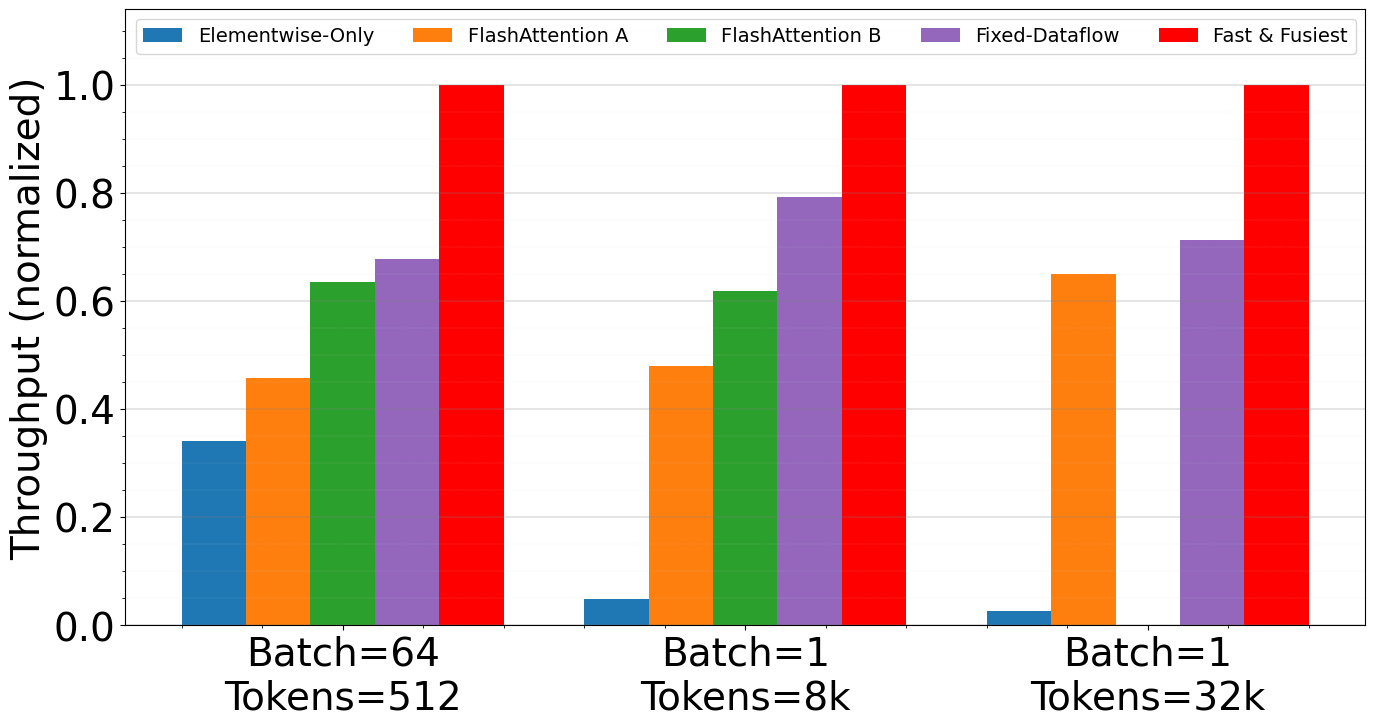

In [2]:
results = parameterization2edp

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({'font.size': 28})

def plot_default_formatting(ax, grid_axis='both'):
    ax.tick_params(axis='both', which='major')#, labelsize=20)
    ax.tick_params(axis='both', which='minor')#, labelsize=20)
    legend = ax.legend()
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('black')
    # Set legend ncols to 5
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.legend(fontsize=14, ncols=5)
    ax.minorticks_on()
    ax.grid(axis=grid_axis, which='major', linestyle='-', linewidth='0.3', color='gray')
    ax.grid(axis=grid_axis, which='minor', linestyle='--', linewidth='0.1', color='lightgray')

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#9467bd",
    "#ff0000",
]

def make_bar_chart(
    data,
    title,
    xlabel,
    ylabel,
    y_scale,
    output_file=None,
    normalize: bool = False,
    ylim=(None, None),
    xlim=(None, None),
):
    """
    Create a bar chart from the given data and save it as a PDF.
    """
    plt.figure(figsize=(16, 8))
    
    if isinstance(data, dict) and isinstance(next(iter(data.values())), dict):
        bar_width = 0.8 / len(data)
        keys = list(next(iter(data.values())).keys())
        x = range(len(keys))
        first = next(iter(data.values()))
            
        for i, (label, values) in enumerate(data.items()):
            bar_positions = [pos + i * bar_width for pos in x]
            to_plot = values
            if normalize:
                to_plot = {k: v / first[k] for k, v in values.items()}
            bars = plt.bar(bar_positions, to_plot.values(), width=bar_width, label=label, color=colors[i])
        plt.xticks([pos + (len(data) - 1) * bar_width / 2 for pos in x], keys)
        # plt.legend(loc='upper right', fontsize=10)
        plt.legend(fontsize=10, ncol=len(data), loc='upper center')
    else:
        keys = list(data.keys())
        bars = plt.bar(keys, data.values())
        

    # Set logarithmic scale for Y-axis if specified
    if y_scale == 'log':
        plt.yscale('log')

    # Add labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Rotate X-axis labels vertically
    # plt.xticks(rotation=90)
    
    plot_default_formatting(plt.gca(), grid_axis='y')
    
    if output_file is not None:
        with open(output_file, 'wb') as f:
            plt.savefig(f, format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

entries = {}

name_changes = {
    "Unfused": "Elementwise-Only",
    "FlashAttention A": "FlashAttention A",
    "FlashAttention B": "FlashAttention B",
    "FFM": "Fast & Fusiest",
    # (64, 512, 64): "Big Batch\n64 Cores",
    (64, 512, 256): "Batch=64\nTokens=512",#\n256 Cores",
    # (1, 16384, 64): "Big Seq\n64 Cores",
    (1, 8192, 256): "Batch=1\nTokens=8k",#\n256 Cores",
    # (1, 32768, 256): "Bigger Seq\n256 Cores",
    (1, 32768, 256): "Batch=1\nTokens=32k",#\n256 Cores",
}

for k, v in results.items():
    if k not in name_changes:
        continue
    k = name_changes.get(k, k)
    entries[k] = {name_changes.get(k2, k2): 1/v[k2] if v[k2] else 0 for k2 in v}
    max_val = max(entries[k].values())
    for k2, v2 in entries[k].items():
        entries[k][k2] = v2 / max_val if max_val else 0
        
entries={k: v for k, v in sorted(entries.items(), key=lambda x: list(name_changes.values()).index(x[0]))}

# Transpose everything
entries2 = {}
for k, v in entries.items():
    for k2, v2 in v.items():
        entries2.setdefault(k2, {})[k] = v2
entries = entries2
        
# Print as a table
for name, e in entries2.items():
    print(f"{name}: {e}")
    
make_bar_chart(entries, title=None, xlabel=None, ylabel="Throughput (normalized)", y_scale='linear', output_file="mapsapce_compare.pdf", normalize=False, ylim=(0, 1.14), xlim=(None, None))